# MaKE MaKI Indices for April 2014 Anomalies, 2 year climatology:

Forecast data from UFS prototype 8. Observations from Scatterometer data.

Filter designed for 15-35 day variability using scatterometer observation, computed with CNN.

EOFs calculated for observations.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from compute_mjo_enso import*

In [2]:
fil1='/scratch/ldoyle4/new_anoms/slice_interp_split/taux_20140101.nc'
#ds1=xr.open_mfdataset(fil1,parallel=True)
ds=xr.open_dataset(fil1)
uflxa=ds.taux_anom
ds.close()

In [32]:
datadir1='/home/ldoyle4/cnn_olr_project/windstress/1535days/'
datadir2='/scratch/ldoyle4/windstress/final/'
#datadir2='/scratch/ldoyle4/windstress/'
filt1=np.loadtxt(datadir1+'taux.filter1.txt', delimiter=',')
filt2=np.loadtxt(datadir1+'taux.filter2.txt', delimiter=',')
#ds1 = xr.open_dataset(datadir2+'obs_taux_eof_1.nc')
#ds1.rename_dims(num='time')
uflx_eof = xr.open_dataset(datadir2+'obs_taux_eof.nc').taux_eof
uflx_eof = uflx_eof.rename(num='time')

In [33]:
flxa_rg = uflxa.stack(grid=("lat","lon")).transpose("time","grid").astype('float32')
flx_eof_rg = uflx_eof.stack(grid=("lat","lon")).transpose("time","grid").astype('float32')

In [79]:
indx = np.squeeze(np.argwhere(~np.isnan(flxa_rg[10,:].data)))
flx = flxa_rg[:,indx]

In [80]:
indx

array([   59,    60,    61, ..., 36613, 36614, 36620])

In [81]:
flx

<xarray.DataArray 'taux_anom' (time: 35, grid: 33430)>
array([[ 0.0091926 ,  0.00684338,  0.00427071, ..., -0.00963739,
        -0.00606826, -0.0007132 ],
       [ 0.0315403 ,  0.0450021 ,  0.04774166, ...,  0.00273446,
         0.00247953,  0.02450372],
       [ 0.04142655,  0.06114218,  0.06283644, ...,  0.01574565,
         0.0117688 ,  0.03637265],
       ...,
       [-0.02045989, -0.02373302, -0.02807311, ...,  0.02981305,
         0.02395572,  0.03645309],
       [-0.03606101, -0.04015278, -0.04683192, ...,  0.00836255,
         0.00733943,  0.042758  ],
       [-0.02966869, -0.02559952, -0.02078156, ..., -0.00963174,
        -0.00948049,  0.01075532]], dtype=float32)
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * grid     (grid) object MultiIndex
  * lat      (grid) float32 -29.0 -29.0 -29.0 -29.0 ... 29.0 29.0 29.0 29.0
  * lon      (grid) float32 153.5 154.0 154.5 155.0 ... 276.0 276.5 277.0 280.0

In [82]:
un = flx_eof_rg[:,indx]
un

<xarray.DataArray 'taux_eof' (time: 4, grid: 33430)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time     (time) int64 1 2 3 4
  * grid     (grid) object MultiIndex
  * lat      (grid) float64 -29.0 -29.0 -29.0 -29.0 ... 29.0 29.0 29.0 29.0
  * lon      (grid) float64 153.5 154.0 154.5 155.0 ... 276.0 276.5 277.0 280.0
Attributes:
    description:  First 4 EOFs of zonal wind stress

In the function below, un became 0 when using the indx for flxa_rg:  

''# find indices where the data is not missing and subset the uflxi
     indx = np.squeeze(np.argwhere(~np.isnan(flxa_rg[10,:].data)))''
     

In [72]:
def calc_tau_MJO(flxa,flx_eof,filt1,filt2):

    # # reshape the data
    flxa_rg = flxa.stack(grid=("lat","lon")).transpose("time","grid").astype('float32')
    flx_eof_rg = flx_eof.stack(grid=("lat","lon")).transpose("time","grid").astype('float32')

    # find indices where the data is not missing and subset the uflxi
    indx = np.squeeze(np.argwhere(~np.isnan(flxa_rg[2,:].data)))
    flx = flxa_rg[:,indx]


    print('Calculating 30-90-day band pass filtered daily UFLX anomalies')

    flxi = copy.deepcopy(flx)
    for i in range(filt1.shape[1]):

        LowPass = np.convolve(flx[:,i],filt1[:,i],mode='same')
        HighPass = flx[:,i] - LowPass
        flxi[:,i] = np.convolve(HighPass,filt2[:,i],mode='same')

    flx_bpf = copy.deepcopy(flxa_rg)	
    flx_bpf[:,indx] = flxi
    flx_bpf = flx_bpf.unstack()
    flx_bpf = flx_bpf.rename('flx_bpf')

    un = flx_eof_rg[:,indx]

    ## Projecting EOFs onto PCs of FLX 30-90 day anomalies

    pct = (un.data@flxi.T.data)/flxi.T.shape[0]
    pc = np.transpose(pct)
    xx = np.std(pc,axis=0,ddof=1)

    flxMJO = np.zeros(flx.T.shape)

    for j in range(4):
      
        r = flxi.T.data@pc[:,j]
        r = r/xx[j]
    
        tt = np.expand_dims(r,1) * np.expand_dims(pct[j,:],0)
    
        flxMJO = flxMJO + tt
    
    flx_MJO = copy.deepcopy(flxa_rg.T)
    flx_MJO[indx,:] = flxMJO

    # Reshape to (time,lat,lon)
    flx_MJO = flx_MJO.unstack()

    flx_MJO = flx_MJO.rename('flx_mjo')

    return flx_MJO


In [73]:
uflx_mjo=calc_tau_MJO(uflxa,uflx_eof,filt1,filt2)

Calculating 30-90-day band pass filtered daily UFLX anomalies


In [74]:
uflx_mjo

<xarray.DataArray 'flx_mjo' (time: 35, lat: 117, lon: 313)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -29.0 -28.5 -28.0 -27.5 -27.0 ... 27.5 28.0 28.5 29.0
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00

In [68]:
uflx_mjo.shape

(35, 117, 313)

In [185]:
fil2='/scratch/ldoyle4/new_anoms/slice_interp_split/tauy_20140101.nc'
ds=xr.open_dataset(fil2)
vflxa=ds.tauy_anom
ds.close()

In [10]:
vflxa = vflxa.drop_duplicates('time', keep='first')

In [186]:
filt1=np.loadtxt(datadir1+'tauy.filter1.txt', delimiter=',')
filt2=np.loadtxt(datadir1+'tauy.filter2.txt', delimiter=',')

#ds1 = xr.open_dataset(datadir2+'obs_taux_eof.nc')
#ds1.rename_dims(num='time')
vflx_eof = xr.open_dataset(datadir2+'obs_tauy_eof.nc').tauy_eof
vflx_eof = vflx_eof.rename(num='time')

In [187]:
vflx_mjo=calc_tau_MJO(vflxa,vflx_eof,filt1,filt2)

Calculating 30-90-day band pass filtered daily UFLX anomalies


In [188]:
vflx_mjo

<xarray.DataArray 'flx_mjo' (time: 35, lat: 117, lon: 313)>
array([[[        nan,         nan,         nan, ..., -0.0349773 ,
         -0.03573712, -0.03655626],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.13737687,  0.14141162,  0.14905107, ...,         nan,
                 nan, -0.00905021]],

       [[        nan,         nan,         nan, ..., -0.00772563,
         -0.00637646, -0.00509622],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.1326963 ,  0.11881901,  0.11388321, ...,         nan,
                 nan, -0.115074  ]],

       [[        nan,         nan,         nan, ...,  0.05698012,
          0.0595455 ,  0.06340726],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.15503958,  0.13668352,  0.12842025, ...,         nan,
                 nan, -0.07397389]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -29.0 -28.5 -28.0 -27.5 -27.0 ... 27.5 28.0 28.5 29.0
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00

In [189]:
vflx_mjo.shape

(35, 117, 313)

In [190]:
fil3='/scratch/ldoyle4/new_anoms/slice_interp_split/ssu_20140101.nc'
ds=xr.open_dataset(fil3)
u=ds.SSU_anom
#u = u.drop_duplicates('time', keep='first')
ds.close()

In [191]:
fil4='/scratch/ldoyle4/new_anoms/slice_interp_split/ssv_20140101.nc'
ds=xr.open_dataset(fil4)
v=ds.SSV_anom
#v = v.drop_duplicates('time', keep='first')
ds.close()

In [192]:
def calc_wpower_MJO(u,v,uflx_mjo,vflx_mjo):

     lat_ws = u.lat
     lon_ws = u.lon

     print('calculating the meridional structure of Kelvin wave')
     import math

     beta=2.28E-11
     hequiv=90
     ynd=lat_ws[len(lat_ws)-1]
     ysd=lat_ws[0]

     cwave=np.sqrt(9.81E-2*hequiv)

     eleq = np.sqrt(cwave/beta)/111000
     yn = ynd/eleq
     ys = ysd/eleq

     dy = (yn-ys)/len(lat_ws)
     dyinv = 2/dy
     enorm = np.sqrt(np.pi)
     anorm = (enorm*(math.erf(yn)+math.erf(-ys)))**(-0.5)

     yy = np.zeros(len(lat_ws))

     for j in range(len(lat_ws)):
         yy[j] = ys+((j+1)-0.5)*dy

     jnot = np.argmin(abs(yy))

     jnot1 = jnot+1

     phik = np.zeros(len(lat_ws))
     phik[jnot] = anorm*np.exp(-0.5*yy[jnot]*yy[jnot])

     for j in range(jnot1,len(lat_ws)):
         phik[j] = phik[j-1]*(dyinv-yy[j-1])/(dyinv+yy[j])

     for j in range(jnot+1):
         k=jnot-j
         phik[k]=phik[k+1]*(dyinv+yy[k+1])/(dyinv-yy[k])


     phik2d = np.ones((len(lat_ws),len(lon_ws)))
     phik2d = phik2d * np.expand_dims(phik,1)

     print('Projecting the ocean current anomalies onto the meridional structure of Kelvin wave')
     u_day_prim_kelvin = u*phik2d
     v_day_prim_kelvin = v*phik2d

     # print('calculating the MJO wind power')
     wmjoks = u_day_prim_kelvin*uflx_mjo.data + v_day_prim_kelvin*vflx_mjo.data
     wmjoks = wmjoks.rename('wmjoks')

     return wmjoks


In [193]:
wpower=calc_wpower_MJO(u,v,uflx_mjo,vflx_mjo)

calculating the meridional structure of Kelvin wave
Projecting the ocean current anomalies onto the meridional structure of Kelvin wave


In [194]:
wpower

<xarray.DataArray 'wmjoks' (time: 35, lat: 117, lon: 313)>
array([[[            nan,             nan,             nan, ...,
          1.88674975e-22,  3.40926399e-22,  5.56369438e-22],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 1.87698975e-21,  1.75602781e-21,  2.08970195e-21, ...,
                     nan,             nan, -8.62527430e-23]],

       [[            nan,             nan,             nan, ...,
         -8.25778028e-23, -3.95059768e-23,  9.01959665e-24],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 2.34966363e-21,  1.11117328e-21,  1.07852006e-21, ...,
                     nan,             nan,  3.45940349e-21]],

       [[            nan,             nan,             nan, ...,
          2.21954073e-22,  8.03366846e-23,  3.90826383e-22],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 2.30372624e-21,  9.29488207e-22,  1.14898153e-21, ...,
                     nan,             nan,  1.80275237e-21]]])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * lat      (lat) float32 -29.0 -28.5 -28.0 -27.5 -27.0 ... 27.5 28.0 28.5 29.0
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [195]:
fil5='/scratch/ldoyle4/new_anoms/slice_interp_split/sst_20140101.nc'
ds = xr.open_dataset(fil5)
sst = ds.SST_anom.sel(lat=slice(-5,5)).mean(dim='lat',skipna=True)
#sst = sst.drop_duplicates('time', keep='first')
ds.close()
meofs=xr.open_dataset('/scratch/ldoyle4/windstress/final/obs_multivarEOFs.nc').multieof

In [196]:
wmjoks = wpower.sel(lat=slice(-5,5)).mean(dim='lat',skipna=True)

In [197]:
wmjoks

<xarray.DataArray 'wmjoks' (time: 35, lon: 313)>
array([[           nan,            nan,            nan, ...,
                   nan, 8.32572395e-05,            nan],
       [           nan,            nan,            nan, ...,
                   nan, 1.59704246e-04,            nan],
       [           nan,            nan,            nan, ...,
                   nan, 4.19879887e-04,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan, 1.52435343e-04,            nan],
       [           nan,            nan,            nan, ...,
                   nan, 4.75414020e-05,            nan],
       [           nan,            nan,            nan, ...,
                   nan, 1.10453163e-03,            nan]])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [198]:
wmjoks = wmjoks.fillna(0)

In [199]:
wmjoks

<xarray.DataArray 'wmjoks' (time: 35, lon: 313)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.32572395e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.59704246e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.19879887e-04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.52435343e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.75414020e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.10453163e-03, 0.00000000e+00]])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [78]:
wmjoks[:,112] = wmjoks[:,111]
wmjoks[:,113] = wmjoks[:,114]

In [216]:
meofs

<xarray.DataArray 'multieof' (num: 2, var: 2, lon: 313)>
array([[[-0.001396, -0.003175, ..., -0.003314, -0.003112],
        [ 0.030277,  0.032927, ..., -0.046098, -0.044281]],

       [[-0.004745, -0.00656 , ..., -0.000107, -0.001301],
        [ 0.000428,  0.000955, ..., -0.000365, -0.000596]]])
Coordinates:
  * var      (var) int64 1 2
  * lon      (lon) float64 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0
  * num      (num) int64 1 2
Attributes:
    description:  Multivariate EOFs: MJO Wind stress and Sea Surface Temperat...

In [217]:
sst

<xarray.DataArray 'SST_anom' (time: 734, lon: 313)>
array([[-0.00873799, -0.07170116, -0.06576462, ..., -0.23877981,
        -0.37655905, -0.37763613],
       [-0.07158513, -0.11985779, -0.07760715, ..., -0.23749341,
        -0.39338347, -0.4302973 ],
       [ 0.00127019, -0.03532847,  0.04527225, ..., -0.15178797,
        -0.3362635 , -0.39741975],
       ...,
       [-0.09617318, -0.11718683, -0.32088184, ...,  0.72060287,
         0.7770406 ,  0.7709888 ],
       [-0.01273526, -0.08281057, -0.32002735, ...,  0.78806466,
         0.8441199 ,  0.86672306],
       [-0.04879072, -0.05370297, -0.2193555 , ...,  0.79379475,
         0.8732916 ,  0.85122526]], dtype=float32)
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2016-01-04 00:00:00
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [200]:
wmjoks_std = wmjoks.std(dim='time',skipna=True)

In [201]:
wmjoks_std

<xarray.DataArray 'wmjoks' (lon: 313)>
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00070888, 0.        ,
       0.        , 0.        , 0.00083905, 0.00034252, 0.0002385 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00140839, 0.00079057, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00095722,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0012243 , 0.        , 0.00086388, 0.        ,
       0.        , 0.0013285 , 0.        , 0.        , 0.        ,
       0.00051827, 0.0056196 , 0.00028752, 0.00182025, 0.00310981,
       0.        , 0.0010729 , 0.00226134, 0.00359502, 0.00286918,
       0.        , 0.00132196, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
...
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00036805, 0.        ])
Coordinates:
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [202]:
nday = sst.time.shape[0]
lon = sst.lon
nlon = len(lon)
num = meofs.num
nnum = len(num)
#nvar = meofs.var.shape[1]

In [203]:
print('Normalizing the SST and MJO wind power data')
sst_std = sst.std(dim='time',skipna=True)
sst_norm = sst/sst_std
wmjoks_std = wmjoks.std(dim='time',skipna=True)
wmjoks_norm = wmjoks/wmjoks_std

Normalizing the SST and MJO wind power data


In [204]:
sst_norm

<xarray.DataArray 'SST_anom' (time: 35, lon: 313)>
array([[-0.08283251, -0.6986884 , -0.6460042 , ..., -0.9682509 ,
        -1.1974733 , -0.95817643],
       [-0.67859733, -1.1679482 , -0.7623331 , ..., -0.9630345 ,
        -1.2509756 , -1.0917937 ],
       [ 0.01204086, -0.34425655,  0.4447082 , ..., -0.6154994 ,
        -1.0693318 , -1.0083734 ],
       ...,
       [-0.23050404, -0.20285705, -1.0203594 , ...,  0.8685602 ,
         1.0606227 ,  1.6629553 ],
       [-1.0497645 , -0.8305193 , -0.9284488 , ...,  1.3227202 ,
         1.2932358 ,  1.667304  ],
       [-0.10446928,  0.42748603, -0.42671525, ...,  2.8032084 ,
         2.1550262 ,  2.1502442 ]], dtype=float32)
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [211]:
wmjoks_norm = wmjoks_norm.fillna(0)

In [212]:
meofs.data

array([[[-1.39638069e-03, -3.17487967e-03, -3.69356704e-03, ...,
         -2.51462046e-03, -3.31416223e-03, -3.11241988e-03],
        [ 3.02765443e-02,  3.29272330e-02,  3.47064313e-02, ...,
         -5.15843204e-02, -4.60984271e-02, -4.42809944e-02]],

       [[-4.74508104e-03, -6.55993101e-03, -3.00698010e-03, ...,
         -2.44385265e-04, -1.06987009e-04, -1.30082403e-03],
        [ 4.27590726e-04,  9.54635076e-04,  1.41817711e-03, ...,
          3.01372775e-05, -3.64786207e-04, -5.95963370e-04]]])

In [213]:
dat_meofs = np.zeros((nnum,nlon*2))
dat_meofs[:,0:nlon] = meofs[:,0,:]
dat_meofs[:,nlon:nlon*2] = meofs[:,1,:]

In [214]:
len(dat_meofs.T)

626

In [215]:
dat = np.zeros((nday,nlon*2))
dat[:,0:nlon] = wmjoks_norm
dat[:,nlon:nlon*2] = sst_norm

In [216]:
len(dat.T)

626

In [217]:
pcs = dat_meofs.data@dat.T

pc1 = -pcs[0,:]
pc2 = -pcs[1,:]

PC1 = pc1/np.std(pc1)  # cfsv2 hindcast?
PC2 = pc2/np.std(pc2)

In [218]:
pc1

array([-49.4182022 , -53.11620054, -55.45018138, -56.81642066,
       -56.01177214, -54.98827368, -53.18170076, -51.64685165,
       -51.3042077 , -49.34047075, -45.8294037 , -43.84198368,
       -43.16134029, -43.09604618, -43.1596516 , -45.86262937,
       -47.66370103, -48.60085043, -49.06653628, -47.7156142 ,
       -47.21108252, -46.6885974 , -48.22840152, -47.72939873,
       -51.26437187, -50.7443824 , -47.02770807, -43.08691011,
       -41.69442587, -40.58757516, -39.11110716, -37.50250407,
       -34.57878545, -32.35394926, -29.11445229])

In [219]:
dat_meofs.data@dat.T

array([[ 4.94182022e+01,  5.31162005e+01,  5.54501814e+01,
         5.68164207e+01,  5.60117721e+01,  5.49882737e+01,
         5.31817008e+01,  5.16468517e+01,  5.13042077e+01,
         4.93404708e+01,  4.58294037e+01,  4.38419837e+01,
         4.31613403e+01,  4.30960462e+01,  4.31596516e+01,
         4.58626294e+01,  4.76637010e+01,  4.86008504e+01,
         4.90665363e+01,  4.77156142e+01,  4.72110825e+01,
         4.66885974e+01,  4.82284015e+01,  4.77293987e+01,
         5.12643719e+01,  5.07443824e+01,  4.70277081e+01,
         4.30869101e+01,  4.16944259e+01,  4.05875752e+01,
         3.91111072e+01,  3.75025041e+01,  3.45787854e+01,
         3.23539493e+01,  2.91144523e+01],
       [-2.00214074e-02, -2.13070844e-02,  1.16880211e-01,
         1.66259164e-02,  1.24886749e-01, -9.20136205e-02,
        -2.15298450e-01, -9.64481545e-02,  2.82797998e-01,
         4.39793307e-01,  2.87353005e-01,  2.35090654e-01,
         2.54861115e-01,  3.79872811e-01,  4.23400588e-01,
         3.22

Text(0.5, 1.0, 'UFS P8 with 1535 Scatterometer Filter')

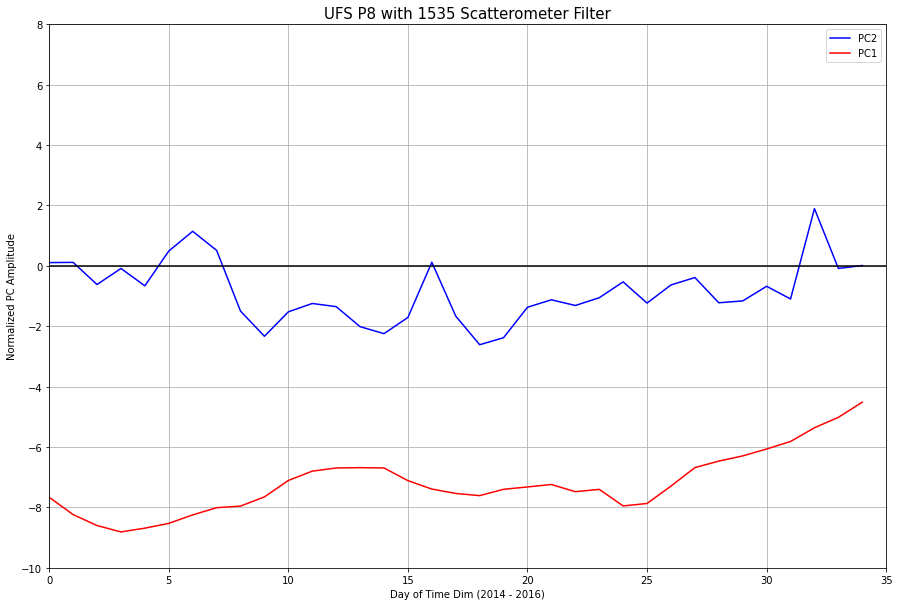

In [224]:
plt.figure(figsize = (15,10))
plt.plot(PC2, 'b')
plt.plot(PC1, 'r')
plt.legend(['PC2','PC1'], loc='best')
plt.grid()
plt.axhline(y=0,color='k')
plt.xlabel('Day of Time Dim (2014 - 2016)')
plt.ylabel('Normalized PC Amplitude')
plt.ylim(ymin=-10,ymax=8)
plt.xlim(xmin=0,xmax=35)
plt.title('UFS P8 with 1535 Scatterometer Filter', fontsize=15)

In [222]:
pcmake = PC1 + np.fabs(PC2)
pcmaki = PC1 + PC2

pcmake = xr.DataArray(pcmake,name='pcmake',coords=[wmjoks.time], dims="time")
pcmaki = xr.DataArray(pcmaki,name='pcmaki',coords=[wmjoks.time], dims="time")

In [66]:
pcmake = pcmake.drop_duplicates('time', keep='first')
pcmaki = pcmaki.drop_duplicates('time', keep='first')

In [223]:
pcmake

<xarray.DataArray 'pcmake' (time: 35)>
array([-7.55838259, -8.12510928, -7.98001181, -8.72383938, -8.02463183,
       -8.0403082 , -7.10599109, -7.49853517, -6.45665936, -5.31910593,
       -5.58336611, -5.55241631, -5.34195273, -4.66854024, -4.44745608,
       -5.40335348, -7.2753547 , -5.87296407, -4.99623033, -5.02013565,
       -5.94991518, -6.1155981 , -6.16604307, -6.34514265, -7.4185919 ,
       -6.63572597, -6.65951715, -6.29367447, -5.24259352, -5.1319538 ,
       -5.38800068, -4.7178009 , -3.47040925, -4.9311355 , -4.5060206 ])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00

In [225]:
pcmaki

<xarray.DataArray 'pcmaki' (time: 35)>
array([ -7.55838259,  -8.12510928,  -9.22029507,  -8.90026656,
        -9.34987708,  -8.0403082 ,  -7.10599109,  -7.49853517,
        -9.45759187,  -9.98600611,  -8.63263442,  -8.0470987 ,
        -8.04643087,  -8.69958952,  -8.94040369,  -8.82295345,
        -7.2753547 ,  -9.20272228, -10.22390891,  -9.78095583,
        -8.69467366,  -8.36691906,  -8.7941119 ,  -8.46022471,
        -8.48330249,  -9.10487087,  -7.92819006,  -7.07162133,
        -7.6907622 ,  -7.4580636 ,  -6.74402539,  -6.91524634,
        -3.47040925,  -5.10486154,  -4.5060206 ])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00

In [156]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

Because we are investigating the MJO influence in April, May, June (AMJ), we set our start date to the 1st april first. And then, we need to change the window of the time delta from 90 to 35 days, since our forecast is initialized every 15 days, and has a length of 35 days per initialization. Then, we need to alter the script to read forward instead of backward, by changing the operation of stdt with the relative delta from subtraction to addition. This means that we are adding 35 days ahead, instead of looking back every 90 days.

In [226]:
startYear = '2014-1-1'
endYear = '2014-2-4'
#startYear=sst['time'][0]
print('startYear=',startYear)
#endYear=sst['time'][-1] 
print('endYear=',endYear)
date_format = '%Y-%m-%d'
stdt = datetime.strptime(startYear, date_format)
edt = datetime.strptime(endYear, date_format)
#stdt = datetime.strptime(str(startYear.values)[0:10], date_format)
print('stdt=',stdt)
#edt = datetime.strptime(str(endYear.values)[0:10], date_format) 
print('edt=',edt)

startYear= 2014-1-1
endYear= 2014-2-4
stdt= 2014-01-01 00:00:00
edt= 2014-02-04 00:00:00


In [67]:
#pcmake.sel(time=pd.date_range(stdt, periods=35),ignore_index=True)

In [43]:
stdt + relativedelta(months=1)

datetime.datetime(2014, 5, 1, 0, 0)

In [227]:
print('Calculating MaKE index')
make = list()
maki = list()

datemin = datetime(stdt.year, stdt.month, stdt.day)
datemax = datetime(edt.year, edt.month, edt.day)
    
print('datemin=',datemin)
print('datemax=',datemax)

while stdt <= edt:
    padt = stdt + relativedelta(days=35)
    make.append(pcmake.sel(time=slice(stdt.strftime(date_format),padt.strftime(date_format))).min('time',skipna='True').data.tolist())
    maki.append(pcmaki.sel(time=slice(stdt.strftime(date_format),padt.strftime(date_format))).min('time',skipna='True').data.tolist())
    stdt = stdt + relativedelta(months=1)
    #print(stdt)

Calculating MaKE index
datemin= 2014-01-01 00:00:00
datemax= 2014-02-04 00:00:00


In [228]:
time_mon = pd.date_range(datemin, datemax, freq='MS')#.to_pydatetime().tolist()
make = xr.DataArray(make,name='make',coords=[time_mon],dims="time")
maki = xr.DataArray(maki,name='maki',coords=[time_mon],dims="time")

make_n = make/np.std(make)
maki_n = maki/np.std(maki)

In [229]:
make_n

<xarray.DataArray 'make' (time: 2)>
array([-4.60032718, -2.60032718])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01

In [230]:
maki_n

<xarray.DataArray 'maki' (time: 2)>
array([-6.18008556, -4.18008556])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01

In [36]:
while stdt <= edt:
    padt = stdt + relativedelta(days=35)
    make.append(pcmake.sel(time=slice(padt.strftime(date_format),stdt.strftime(date_format))).min('time',skipna='True').data.tolist())
    maki.append(pcmaki.sel(time=slice(padt.strftime(date_format),stdt.strftime(date_format))).min('time',skipna='True').data.tolist())
    stdt = stdt + relativedelta(months=1)
    #print(stdt)
    
time_mon = pd.date_range(datemin, datemax, freq='MS')#.to_pydatetime().tolist()
make = xr.DataArray(make,name='make',coords=[time_mon],dims="time")
maki = xr.DataArray(maki,name='maki',coords=[time_mon],dims="time")

make_n = make/np.std(make)
maki_n = maki/np.std(maki)

KeyError: cftime.DatetimeJulian(2014, 1, 1, 23, 59, 59, 999999, has_year_zero=False)

In [142]:
stdt

datetime.datetime(2014, 1, 1, 0, 0)

In [92]:
time_mon

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [42]:
make_n

<xarray.DataArray 'make' (time: 345)>
array([ 2.57706961e-01, -6.49814915e-01, -1.53748845e+00, -1.73410410e+00,
       -1.73410410e+00, -1.48316770e+00, -1.29962950e+00, -1.85336069e+00,
       -2.17094646e+00, -2.17094646e+00, -1.64162125e+00, -1.42070045e+00,
       -1.22354685e+00, -6.71157630e-01, -7.51495014e-01, -5.97040584e-01,
       -4.79322629e-01, -6.00705439e-01, -6.03277029e-01, -5.87871311e-01,
       -4.93771049e-01, -8.02889759e-02,  4.40939744e-02,  2.55872430e-01,
        1.29955893e-01,  1.47080310e-01,  1.50336595e-01,  1.50416494e-01,
       -7.44483379e-02,  1.45513290e-01,  1.98172366e-01,  2.11352515e-01,
        2.11061072e-01,  6.26054419e-01,  7.27987736e-01,  4.82905013e-01,
        3.72637953e-01,  1.85266359e-01,  2.62482002e-01,  8.20200321e-01,
        7.69347681e-01,  7.34165527e-01,  7.47141684e-01,  1.00121551e+00,
        1.31884976e+00,  1.69063706e+00,  1.73042700e+00,  1.63290320e+00,
        1.54752621e+00,  1.31488713e+00,  1.09915177e+00,  5.35831856e-01,
        4.26619690e-01,  2.95224971e-01,  8.44690002e-04,  6.07013209e-02,
        6.07013209e-02,  1.56706379e-01,  6.17004507e-01,  6.78824277e-01,
        5.32530368e-01,  8.39861507e-01,  1.10030136e+00,  1.16381430e+00,
        5.31565434e-01,  5.31565434e-01,  8.00761246e-01,  8.54018861e-01,
        5.79689543e-01,  4.95135174e-01,  2.82645324e-01,  4.34237305e-03,
       -3.83842225e-01, -3.83842225e-01, -7.94919779e-02,  2.35251629e-01,
        2.35251629e-01,  1.92480223e-01,  7.53789399e-01,  1.17429785e+00,
...
       -1.13860429e+00, -1.84177572e+00, -1.84177572e+00, -2.01680031e+00,
       -1.85777020e+00, -2.02601944e+00, -1.97131381e+00, -1.43571636e+00,
       -1.00376720e+00, -7.73042729e-01, -3.75380295e-01, -2.33253911e-01,
       -1.52683050e-01, -4.89323503e-01, -6.83725746e-01, -9.21106337e-01,
       -1.14017026e+00, -1.16137422e+00, -1.19074518e+00, -1.14299346e+00,
       -6.48974463e-01, -3.93383825e-01, -5.81075275e-02,  1.60732312e-01,
        4.25133867e-01,  4.98521040e-01,  4.50486339e-01,  1.70823950e-01,
        1.02997766e-01,  1.02997766e-01, -6.68599467e-01, -6.68599467e-01,
       -3.91952345e-01, -4.89058712e-01, -4.66012152e-01, -6.08216132e-01,
       -6.44597926e-01, -6.52079441e-01, -3.57371636e-01, -1.84333263e-01,
       -3.82983320e-02, -2.14413625e-01, -3.60852595e-01, -2.09966343e-01,
        3.11041749e-01,  3.64988027e-01,  4.21249669e-01,  6.47826253e-01,
        2.13275199e-01,  2.74509134e-01,  3.17860363e-01,  5.00548540e-01,
        8.12567347e-01,  6.50753873e-01,  6.50753873e-01,  5.78565776e-01,
        9.20523607e-01,  9.49864127e-01,  1.20381364e+00,  1.47775060e+00,
        1.88393419e+00,  1.93957923e+00,  2.32374003e+00,  2.32374003e+00,
        2.54863354e+00,  2.59443336e+00,  2.24598897e+00,  1.76555687e+00,
        1.67046872e+00,  1.11305622e+00,  2.44369273e-01, -1.60663196e-01,
       -5.19802852e-01, -5.57343341e-01, -4.47730119e-01, -6.39674106e-01,
       -6.71953948e-01])
Coordinates:
  * time     (time) datetime64[ns] 1988-04-01 1988-05-01 ... 2016-12-01

In [43]:
maki_n

<xarray.DataArray 'maki' (time: 345)>
array([-2.93146639, -3.68856754, -1.33421235, -1.6263547 , -1.68526506,
       -1.49413815, -0.9545681 , -2.92171478, -1.57921889, -1.57921889,
       -2.44115657, -2.71046418, -2.87225078, -2.87225078, -2.35401643,
       -1.11394405, -0.9575401 , -1.09761863, -0.82565669, -0.93252901,
       -0.93252901, -0.36663279, -0.45955433, -0.93741828, -0.93741828,
       -2.02004706, -0.44803646, -1.53028785, -0.9169617 , -0.12518856,
       -0.56620274,  0.09723119,  0.03028777, -0.59210042, -0.11868029,
       -0.86650346, -0.52339415, -0.0658775 , -0.14260489, -0.0948263 ,
        0.47197221,  0.23740844,  0.54349579,  0.64733657,  0.60400238,
        0.52650681,  0.25152008,  0.25152008, -1.480467  , -1.11454486,
       -2.6090048 , -4.03100854, -2.78398073, -3.77885968, -3.77885968,
       -1.95545247, -1.0921978 , -1.50701022, -1.50701022, -2.086039  ,
       -0.71783311,  0.53264973,  0.64073081, -0.25962058, -0.67338726,
       -1.33504593, -0.02247425, -0.09513611,  0.10046678, -0.62494621,
       -0.62494621, -0.71874376, -0.71874376, -0.75520298, -0.46436926,
       -1.45946171, -0.75427872, -1.27045768,  0.42377336,  0.85422343,
        0.10315626,  0.10315626, -0.51736256, -0.41984623, -1.22461512,
       -1.14748288, -1.14469957, -1.14469957, -2.26208972, -0.42961604,
       -1.13831142, -1.01502428, -0.92465335, -1.04185696, -1.39820253,
       -1.00475988, -0.68462144, -0.68234779, -1.05539983, -1.1170646 ,
...
       -0.39295247, -0.52799106, -1.00766045, -1.09938935, -2.08821801,
       -1.4236374 , -2.39866516, -2.39866516, -2.93099255, -0.26181724,
       -0.30632319, -0.02827747,  0.10379262, -0.08739427,  0.40872445,
       -0.83734075,  0.08001151,  0.08001151,  0.28848269,  0.45185396,
       -0.03346296, -1.13396264, -1.72142923, -1.22213891, -1.5497653 ,
       -1.5497653 , -1.5578399 , -1.81796179, -2.13800911, -2.97585774,
       -2.97585774, -2.94570041, -1.47507469, -1.3735733 , -1.1655863 ,
       -1.34059217, -0.59152465, -1.08809138, -1.31645512, -1.0595643 ,
       -0.87133833, -0.93615628, -1.07261674, -1.2799943 , -1.63638547,
       -0.97471245, -0.56061728, -1.92934621, -0.75669075, -0.69893443,
       -0.05269742, -0.08350174, -0.05690403, -1.16262178, -1.04752888,
       -0.44219115, -0.60280385, -1.97827667, -1.97827667, -1.3101063 ,
       -0.74756913, -0.56984522, -0.62129093, -0.71130114, -0.20370349,
       -0.53172938, -1.11606752, -2.0462269 , -0.37082625,  0.1533317 ,
        0.00407752, -0.30276794, -0.2821435 ,  0.09607865,  0.35438332,
        0.35703175,  0.3677029 ,  0.44408805, -0.16733078, -0.28300377,
        0.26565741,  0.65309922,  0.67624332,  0.72119219,  0.85647595,
        1.66542537,  1.47888727,  1.48595006,  1.51543939,  0.94394854,
        0.89540677, -1.44866473, -1.44866473, -2.17158785, -1.85227091,
       -1.07975003, -1.13375608, -1.10338894, -1.3776087 , -0.98751083])
Coordinates:
  * time     (time) datetime64[ns] 1988-04-01 1988-05-01 ... 2016-12-01

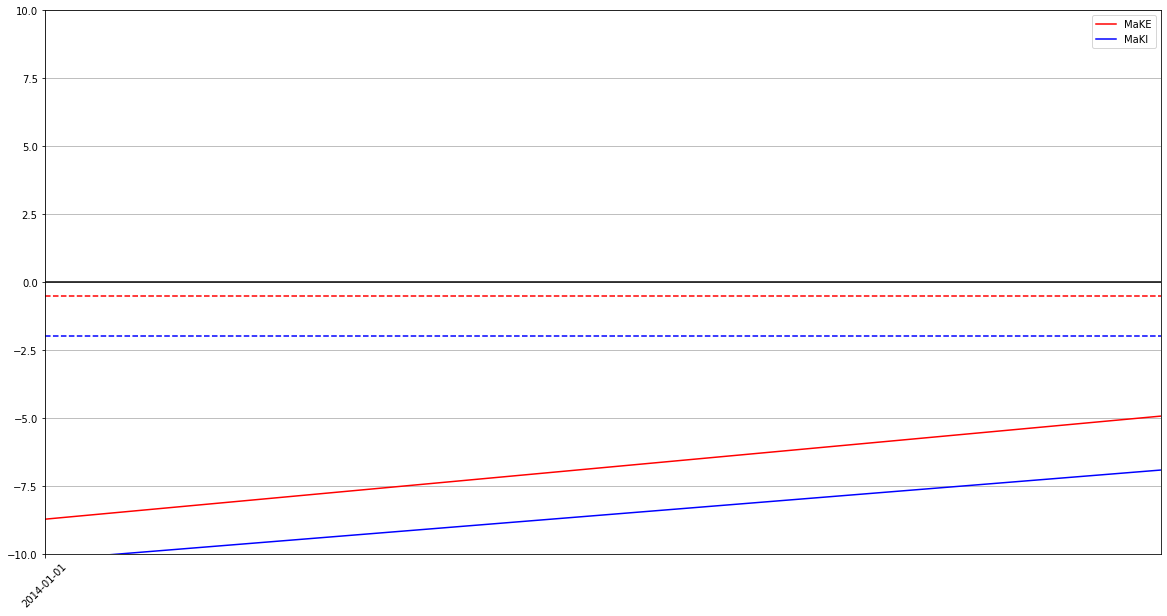

In [232]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(time_mon,make,'r')
plt.plot(time_mon,maki,'b')
plt.axhline(y=0,color='k')
plt.axhline(y=-0.5,color='r',linestyle='--')
plt.axhline(y=-2,color='b',linestyle='--')
plt.xlim([time_mon[0],time_mon[len(time_mon)-1]])
plt.xticks(time_mon[0::12], rotation=45)
plt.ylim([-10,10])
plt.grid();
plt.legend(['MaKE','MaKI'], loc='best')
#plt.savefig('MaKE-MaKI.png')


In [74]:
def make_maki(sst,wmjoks,meofs):
    print('I am in  make_maki')

    nday = sst.time.shape[0]
    lon = sst.lon
    nlon = len(lon)

    print('Normalizing the SST and MJO wind power data')
    sst_std = sst.std(dim='time',skipna=True)
    sst_norm = sst/sst_std

    wmjoks_std = wmjoks.std(dim='time',skipna=True)
    wmjoks_norm = wmjoks/wmjoks_std

    print('Creating multivariable matrix')
    dat_meofs = np.zeros((nnum,nlon*2))
    dat_meofs[:,0:nlon] = meofs[:,0,:]
    dat_meofs[:,nlon:nlon*2] = meofs[:,1,:]
    
    dat = np.zeros((nday,nlon*2))
    dat[:,0:nlon] = wmjoks_norm
    dat[:,nlon:nlon*2] = sst_norm

    print('Calculating the multivariate PCs')

    #meofs = xr.open_dataset('cfs_multivarEOF.nc').meofs

    ### If the multivariate EOFs need to be updated run this section
    # from geocat.ncomp import eofunc, eofunc_ts

    # neof = 2
    # eofs = eofunc(dat.T, neof)
    # eofs = eofs.rename({'evn':'eofs','dim_0':'lonn'})
    # eofs = eofs.rename('meofs')
    # eofs.to_netcdf('cfs_multivarEOFs.nc')


    pcs = dat_meofs.data@dat.T

    pc1 = -pcs[0,:]
    pc2 = -pcs[1,:]

    PC1 = pc1/np.std(pc1)  # cfsv2 hindcast?
    PC2 = pc2/np.std(pc2)

    # Calculate MaKE and MaKI index

    pcmake = PC1 + np.fabs(PC2)
    pcmaki = PC1 + PC2

    pcmake = xr.DataArray(pcmake,name='pcmake',coords=[wmjoks.time], dims="time")
    pcmaki = xr.DataArray(pcmaki,name='pcmaki',coords=[wmjoks.time], dims="time")

    ###### Two Options #######

    # Minimum of 3 MONTHS. For example, April value = min (A,M,J)
    # Minimum of 90 days. For example, April value = min (April 1st - June 29th)

    ###########################

    from datetime import datetime
    from dateutil.relativedelta import relativedelta

    #startYear = '1990-4-1'
    #endYear = '2021-12-1'
    startYear=sst['time'][90]
    print('startYear=',startYear)
    endYear=sst['time'][-1] 
    print('endYear=',endYear)
    date_format = '%Y-%m-%d'
    #stdt = datetime.strptime(startYear, date_format)
    #edt = datetime.strptime(endYear, date_format)
    stdt = datetime.strptime(str(startYear.values)[0:10], date_format)
    print('stdt=',stdt)
    edt = datetime.strptime(str(endYear.values)[0:10], date_format) 
    print('edt=',edt)

    print('Calculating MaKE index')
    make = list()
    maki = list()
    
    datemin = datetime(stdt.year, stdt.month, stdt.day)
    datemax = datetime(edt.year, edt.month, edt.day)
    
    print('datemin=',datemin)
    print('datemax=',datemax)

    while stdt <= edt:
        padt = stdt - relativedelta(days=35)
        make.append(pcmake.sel(time=slice(padt.strftime(date_format),stdt.strftime(date_format))).min('time',skipna='True').data.tolist())
        maki.append(pcmaki.sel(time=slice(padt.strftime(date_format),stdt.strftime(date_format))).min('time',skipna='True').data.tolist())
        stdt = stdt + relativedelta(months=1)
    
    time_mon = pd.date_range(datemin, datemax, freq='MS')#.to_pydatetime().tolist()
    make = xr.DataArray(make,name='make',coords=[time_mon],dims="time")
    maki = xr.DataArray(maki,name='maki',coords=[time_mon],dims="time")

    make_n = make/np.std(make)
    maki_n = maki/np.std(maki)

    import csv
    with open('make-maki.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Date", "MaKE", "MaKI"])
        for i in range(len(make_n)):
            writer.writerow([time_mon[i], make_n[i].data, maki_n[i].data])


    import matplotlib.pyplot as plt

    plt.figure(figsize=(20,10))
    plt.plot(time_mon,make,'r')
    plt.plot(time_mon,maki,'b')
    plt.axhline(y=0,color='k')
    plt.axhline(y=-0.5,color='r',linestyle='--')
    plt.axhline(y=-2,color='b',linestyle='--')
    plt.xlim([time_mon[0],time_mon[len(time_mon)-1]])
    #plt.xticks(time_year)
    plt.ylim([-8,3])
    plt.grid();
    plt.legend(['MaKE','MaKI'], loc='best')
    plt.savefig('MaKE-MaKI.png')

    return make_n,maki_n

I am in  make_maki
Normalizing the SST and MJO wind power data
Creating multivariable matrix
Calculating the multivariate PCs
startYear= <xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1988, 4, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1988-04-01 00:00:00
Attributes:
    long_name:  Time
endYear= <xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2016, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 2016-12-31 00:00:00
Attributes:
    long_name:  Time
stdt= 1988-04-01 00:00:00
edt= 2016-12-31 00:00:00
Calculating MaKE index
datemin= 1988-04-01 00:00:00
datemax= 2016-12-31 00:00:00


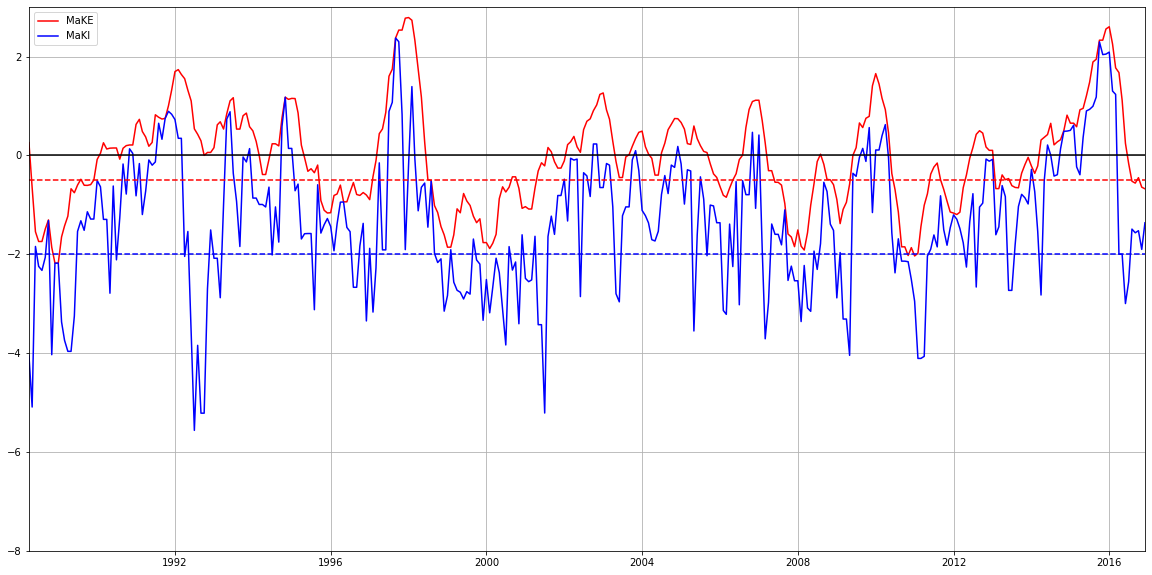

In [75]:
make,maki=make_maki(sst,wmjoks,meofs)